In [1]:
from deeprxn.featurizer.featurizer import make_featurizer
from deeprxn.utils import set_seed, load_standardizer, load_model
from deeprxn.visualize import visualize_graphs
from torch_geometric.utils import subgraph
from omegaconf import OmegaConf
from hydra import initialize, compose
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import hydra
import os
from deeprxn.representation.rxn_graph import AtomOriginType
from torch_geometric.utils import to_dense_batch
os.chdir('..')

In [2]:
# read pkl file data/seed0.pkl
import pickle 
file = open('data/barriers_b97d3/seed0.pkl', 'rb')
b97 = pickle.load(file)
file.close()
file = open('data/barriers_rdb7low/seed0.pkl', 'rb')
rdb7low = pickle.load(file)
file.close()
file = open('data/barriers_rdb7new/seed0.pkl', 'rb')
rdb7new = pickle.load(file)
file.close()
print(len(b97[0][0]), len(b97[0][1]), len(b97[0][2]), len(rdb7low[0][0]), len(rdb7low[0][1]), len(rdb7low[0][2]), len(rdb7new[0][0]), len(rdb7new[0][1]), len(rdb7new[0][2]))
#print(all(data[0][0] == smi[0][0]), all(data[0][1] == smi[0][1]), all(data[0][2] == smi[0][2]))

27712 1626 3266 20274 1192 2386 20274 1192 2386


In [6]:
# read csv data/barriers_b97d3/data.csv
import pandas as pd
df = pd.read_csv('data/barriers_b97d3/data.csv')
df_2 = pd.read_csv('data/barriers_rdb7low/data.csv')
df_3 = pd.read_csv('data/barriers_rdb7new/data.csv')
print(len(df), len(df_2), len(df_3))
df_2.head(), df_3.head()

32604 23852 23852


(                                          rxn_smiles         ea        dh
 0  [C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...   48.73925  21.40228
 1  [C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...   27.33697 -21.40228
 2  [C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...   74.31711  21.57450
 3  [C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...   52.74261 -21.57450
 4  [C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...  102.81328  13.09638,
                                           rxn_smiles        ea        dh
 0  [C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...  48.61085  26.77621
 1  [C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...  21.83464 -26.77621
 2  [C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...  74.02980  28.79099
 3  [C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...  45.23881 -28.79099
 4  [C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...  97.42200  12.60220)

In [2]:
import torch
from torch_geometric.utils import to_dense_adj
edge_index = torch.tensor([[0, 0, 1, 2, 3],
                           [0, 1, 0, 3, 0]])
batch = torch.tensor([0, 0, 1, 1])
print(to_dense_adj(edge_index, batch))
tensor1 = torch.tensor([[0, 0, 1, 2, 3],
                           [0, 1, 0, 3, 0]])
tensor2 = torch.tensor([[0, 0, 1, 2, 3],
                           [0, 1, 0, 3, 0]])
tensor3 = torch.tensor([[0, 0, 1, 2, 3],
                           [0, 1, 0, 3, 0]])
print(torch.cat([tensor1, tensor2, tensor3], dim=0))

tensor([[[1., 1.],
         [1., 0.]],

        [[0., 1.],
         [1., 0.]]])
tensor([[0, 0, 1, 2, 3],
        [0, 1, 0, 3, 0],
        [0, 0, 1, 2, 3],
        [0, 1, 0, 3, 0],
        [0, 0, 1, 2, 3],
        [0, 1, 0, 3, 0]])


In [3]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="cfg_cp")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(cfg.seed)
cfg.data.batch_size = 2
train_loader = hydra.utils.instantiate(
    cfg.data, shuffle=True, split="train"
)
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[61, 99], edge_index=[2, 214], edge_attr=[214, 2], y=[2], smiles=[2], atom_origin_type=[61], edge_origin_type=[214], atom_compound_idx=[61], randomwalkpe=[61, 3], batch=[61], ptr=[3])


In [5]:
batch[0].randomwalkpe

tensor([[0.0000, 0.2917, 0.1713, 0.2033, 0.1816, 0.1824, 0.1750, 0.1724, 0.1684,
         0.1660, 0.1634, 0.1615, 0.1597, 0.1583, 0.1570, 0.1560, 0.1550, 0.1543,
         0.1536, 0.1531, 0.1526, 0.1522, 0.1519, 0.1516, 0.1514, 0.1512, 0.1510,
         0.1508, 0.1507, 0.1506, 0.1505, 0.1504, 0.1504, 0.1503, 0.1503, 0.1502,
         0.1502, 0.1502, 0.1501, 0.1501],
        [0.0000, 0.2778, 0.1481, 0.1644, 0.1381, 0.1306, 0.1201, 0.1132, 0.1069,
         0.1019, 0.0977, 0.0942, 0.0913, 0.0888, 0.0867, 0.0849, 0.0834, 0.0821,
         0.0811, 0.0801, 0.0794, 0.0787, 0.0782, 0.0777, 0.0773, 0.0769, 0.0766,
         0.0764, 0.0762, 0.0760, 0.0759, 0.0757, 0.0756, 0.0755, 0.0754, 0.0754,
         0.0753, 0.0753, 0.0752, 0.0752],
        [0.0000, 0.2778, 0.1481, 0.1644, 0.1381, 0.1306, 0.1201, 0.1132, 0.1069,
         0.1019, 0.0977, 0.0942, 0.0913, 0.0888, 0.0867, 0.0849, 0.0834, 0.0821,
         0.0811, 0.0801, 0.0794, 0.0787, 0.0782, 0.0777, 0.0773, 0.0769, 0.0766,
         0.0764, 0.0762, 

In [5]:
batch = next(iter(train_loader))
batch.atom_compound_idx

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
def get_mask(batch, mode, num_heads=3):
    device = batch.x.device

    x_dense, mask = to_dense_batch(batch.x, batch.batch, fill_value=0)
    atom_types_dense, _ = to_dense_batch(
        batch.atom_origin_type, batch.batch, fill_value=-1
    )

    batch_size, max_nodes, _ = x_dense.size()

    if mode in ["intra", "inter", "compound", "local_inter", "local_compound_inter", "local_compound"]:
        is_reactant = atom_types_dense == AtomOriginType.REACTANT.value
        is_product = atom_types_dense == AtomOriginType.PRODUCT.value

    attention_mask = torch.zeros(
        (batch_size, max_nodes, max_nodes),
        dtype=torch.bool,
        device=device,
    )
    attention_mask.diagonal(dim1=1, dim2=2)[:] = (
        ~mask
    )  # this is important due to bug with padding

    if mode == "local":  # TODO: check to make more efficient
        for b in range(batch_size):
            batch_mask = batch.batch == b
            batch_nodes = batch_mask.nonzero().squeeze()

            edge_mask = batch_mask[batch.edge_index[0]]
            batch_edges = batch.edge_index[:, edge_mask]

            local_edges = batch_edges - batch_nodes[0]

            attention_mask[b, local_edges[0], local_edges[1]] = True
            attention_mask[b, local_edges[1], local_edges[0]] = True

            attention_mask[b].diagonal()[: mask[b].sum()] = True

    if mode == "inter":
        attention_mask = torch.logical_or(
            attention_mask,
            is_reactant.unsqueeze(-1) & is_product.unsqueeze(1),
        )
        attention_mask = torch.logical_or(
            attention_mask,
            is_product.unsqueeze(-1) & is_reactant.unsqueeze(1),
        )

    if mode == "intra":
        structure_attention = (
            is_reactant.unsqueeze(-1) & is_reactant.unsqueeze(1)
        ) | (is_product.unsqueeze(-1) & is_product.unsqueeze(1))

        attention_mask = attention_mask | structure_attention

    if mode == "compound":
        compound_idx_dense, _ = to_dense_batch(
            batch.atom_compound_idx, batch.batch, fill_value=-1
        )
        
        compound_attention = compound_idx_dense.unsqueeze(-1) != compound_idx_dense.unsqueeze(1)
        
        self_attention = torch.eye(max_nodes, dtype=torch.bool, device=device)
        self_attention = self_attention.unsqueeze(0).expand(batch_size, -1, -1)
        self_attention = self_attention & mask.unsqueeze(-1)  
        structure_attention = (
            is_reactant.unsqueeze(-1) & is_reactant.unsqueeze(1)
        ) | (is_product.unsqueeze(-1) & is_product.unsqueeze(1))
        
        attention_mask = attention_mask | (structure_attention & compound_attention) | self_attention

    if mode == "local_inter":
        # Create local mask first
        for b in range(batch_size):
            batch_mask = batch.batch == b
            batch_nodes = batch_mask.nonzero().squeeze()

            edge_mask = batch_mask[batch.edge_index[0]]
            batch_edges = batch.edge_index[:, edge_mask]

            local_edges = batch_edges - batch_nodes[0]

            attention_mask[b, local_edges[0], local_edges[1]] = True
            attention_mask[b, local_edges[1], local_edges[0]] = True

            attention_mask[b].diagonal()[: mask[b].sum()] = True

        # Add inter-molecular attention
        attention_mask = torch.logical_or(
            attention_mask,
            is_reactant.unsqueeze(-1) & is_product.unsqueeze(1),
        )
        attention_mask = torch.logical_or(
            attention_mask,
            is_product.unsqueeze(-1) & is_reactant.unsqueeze(1),
        )

    if mode == "local_compound":
        # Local connections first
        for b in range(batch_size):
            batch_mask = batch.batch == b
            batch_nodes = batch_mask.nonzero().squeeze()

            edge_mask = batch_mask[batch.edge_index[0]]
            batch_edges = batch.edge_index[:, edge_mask]

            local_edges = batch_edges - batch_nodes[0]

            attention_mask[b, local_edges[0], local_edges[1]] = True
            attention_mask[b, local_edges[1], local_edges[0]] = True

            attention_mask[b].diagonal()[: mask[b].sum()] = True

        # Compound attention
        compound_idx_dense, _ = to_dense_batch(
            batch.atom_compound_idx, batch.batch, fill_value=-1
        )
        compound_attention = compound_idx_dense.unsqueeze(-1) != compound_idx_dense.unsqueeze(1)

        # Self attention
        self_attention = torch.eye(
            max_nodes, dtype=torch.bool, device=device
        )
        self_attention = self_attention.unsqueeze(0).expand(
            batch_size, -1, -1
        )
        self_attention = self_attention & mask.unsqueeze(-1)

        # Structure attention (within reactants/products)
        structure_attention = (
            is_reactant.unsqueeze(-1) & is_reactant.unsqueeze(1)
        ) | (is_product.unsqueeze(-1) & is_product.unsqueeze(1))

        # Combine masks
        attention_mask = (
            attention_mask  # local connections
            | (structure_attention & compound_attention)  # compound attention within same type
            | self_attention  # self attention
        )

    if mode == "local_compound_inter":
        # Local connections first
        for b in range(batch_size):
            batch_mask = batch.batch == b
            batch_nodes = batch_mask.nonzero().squeeze()

            edge_mask = batch_mask[batch.edge_index[0]]
            batch_edges = batch.edge_index[:, edge_mask]

            local_edges = batch_edges - batch_nodes[0]

            attention_mask[b, local_edges[0], local_edges[1]] = True
            attention_mask[b, local_edges[1], local_edges[0]] = True

            attention_mask[b].diagonal()[: mask[b].sum()] = True

        # Compound attention
        compound_idx_dense, _ = to_dense_batch(
            batch.atom_compound_idx, batch.batch, fill_value=-1
        )
        compound_attention = compound_idx_dense.unsqueeze(-1) != compound_idx_dense.unsqueeze(1)

        # Self attention
        self_attention = torch.eye(
            max_nodes, dtype=torch.bool, device=device
        )
        self_attention = self_attention.unsqueeze(0).expand(
            batch_size, -1, -1
        )
        self_attention = self_attention & mask.unsqueeze(-1)

        # Structure attention (within reactants/products)
        structure_attention = (
            is_reactant.unsqueeze(-1) & is_reactant.unsqueeze(1)
        ) | (is_product.unsqueeze(-1) & is_product.unsqueeze(1))

        # Inter-molecular attention
        inter_attention = torch.logical_or(
            is_reactant.unsqueeze(-1) & is_product.unsqueeze(1),
            is_product.unsqueeze(-1) & is_reactant.unsqueeze(1),
        )

        # Combine all masks
        attention_mask = (
            attention_mask  # local connections
            | (structure_attention & compound_attention)  # compound attention within same type
            | self_attention  # self attention
            | inter_attention  # reactant-product attention
        )

    if mode == "self":
        attention_mask = None
    else:
        attention_mask = attention_mask.repeat_interleave(
            num_heads, dim=0
        )
        attention_mask = ~attention_mask

    return attention_mask
mask = get_mask(batch, "local_compound")
print(mask[0])

tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False, False,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False,  True, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False,  True, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  T

In [7]:
batch[0].atom_compound_idx

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [8]:
mask[0]

tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False, False,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False,  True, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False,  True, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  T

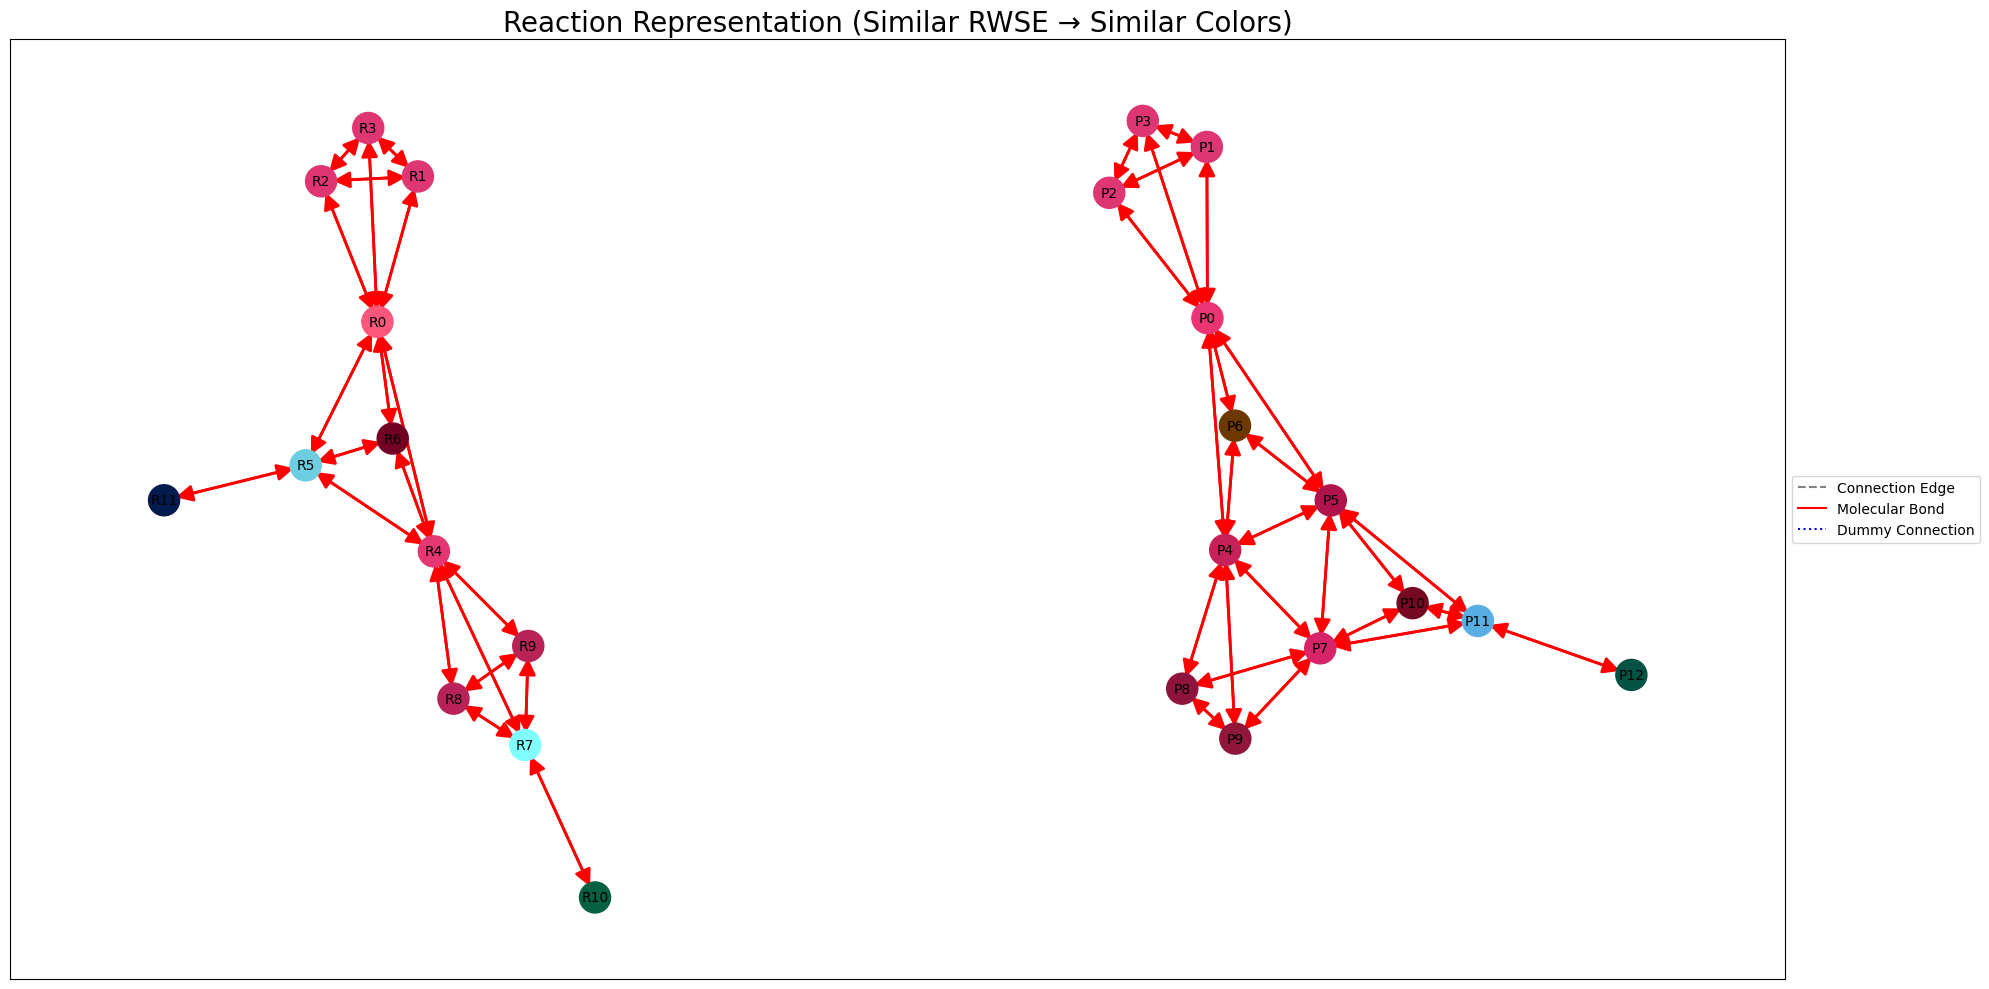

In [4]:
from deeprxn.visualize import visualize_graphs_with_randomwalk_dict, visualize_graphs_with_similar_rwse
visualize_graphs_with_similar_rwse(batch[0], batch[0].randomwalkpe)

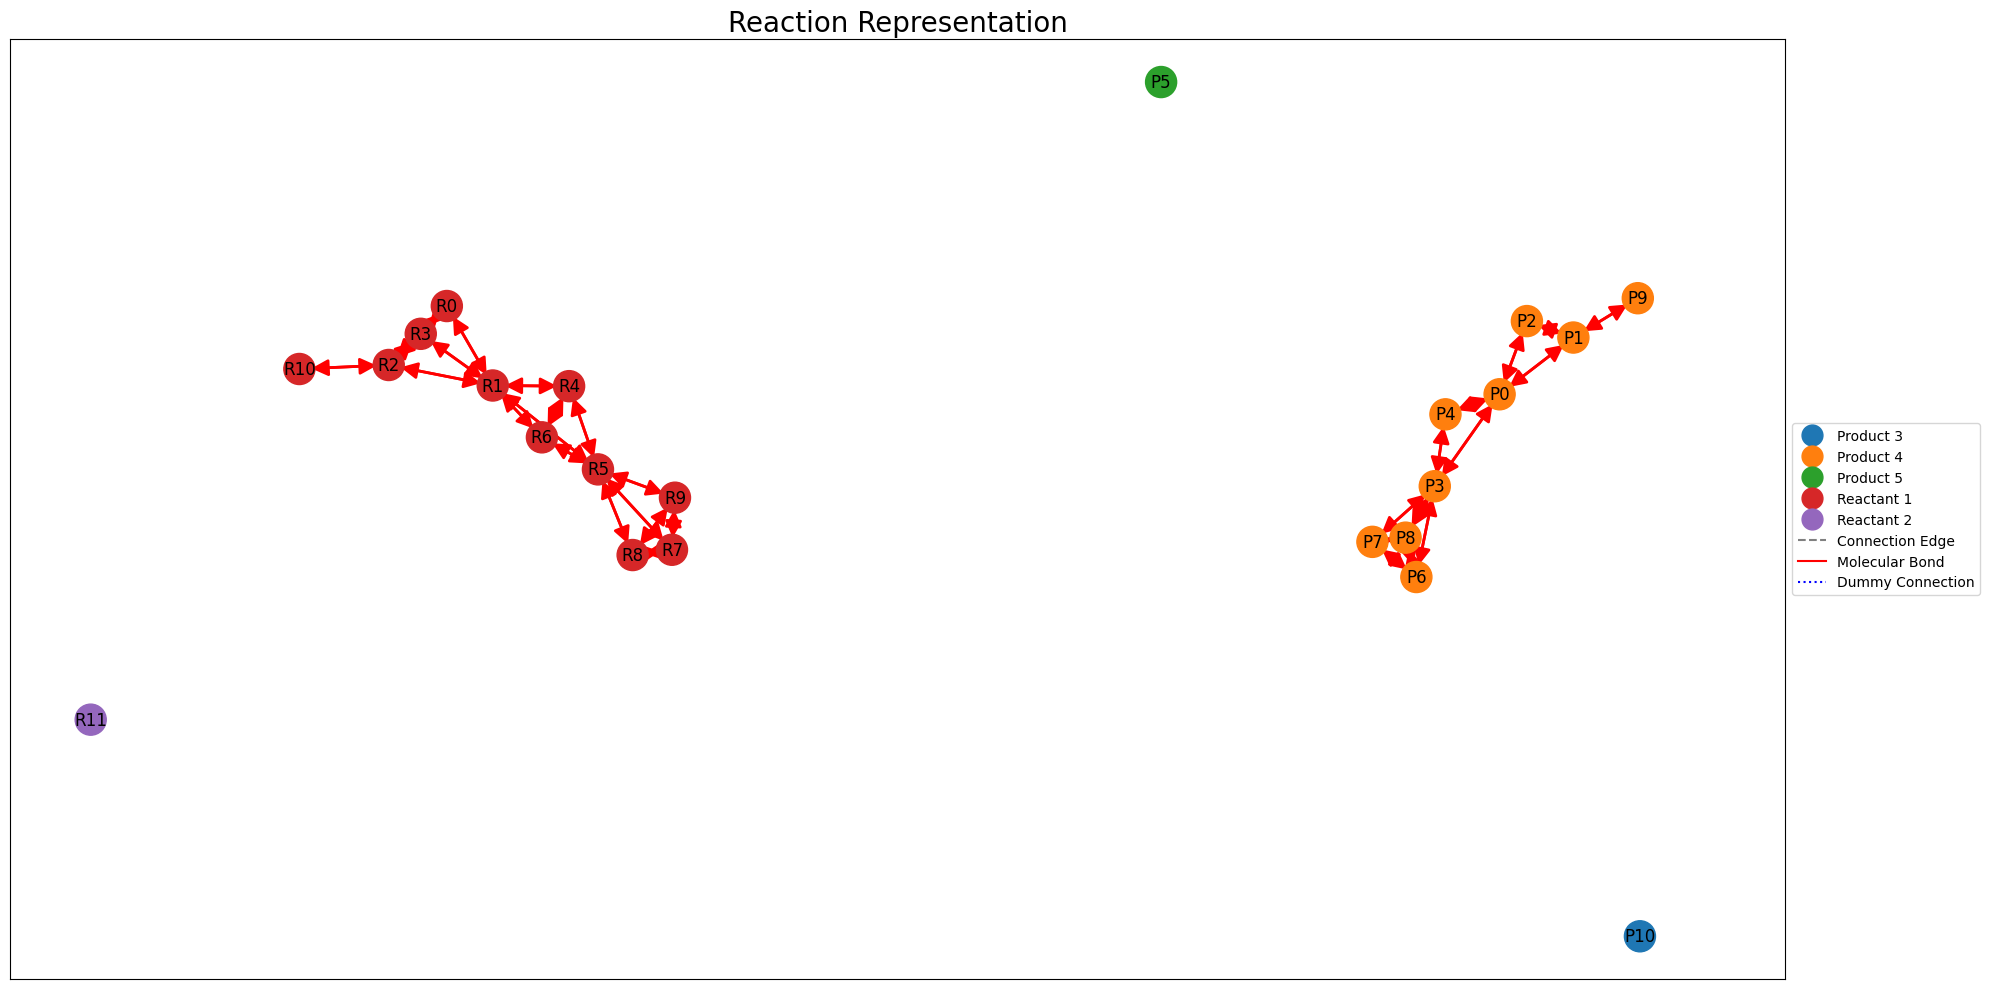

In [4]:
visualize_graphs(batch[0])

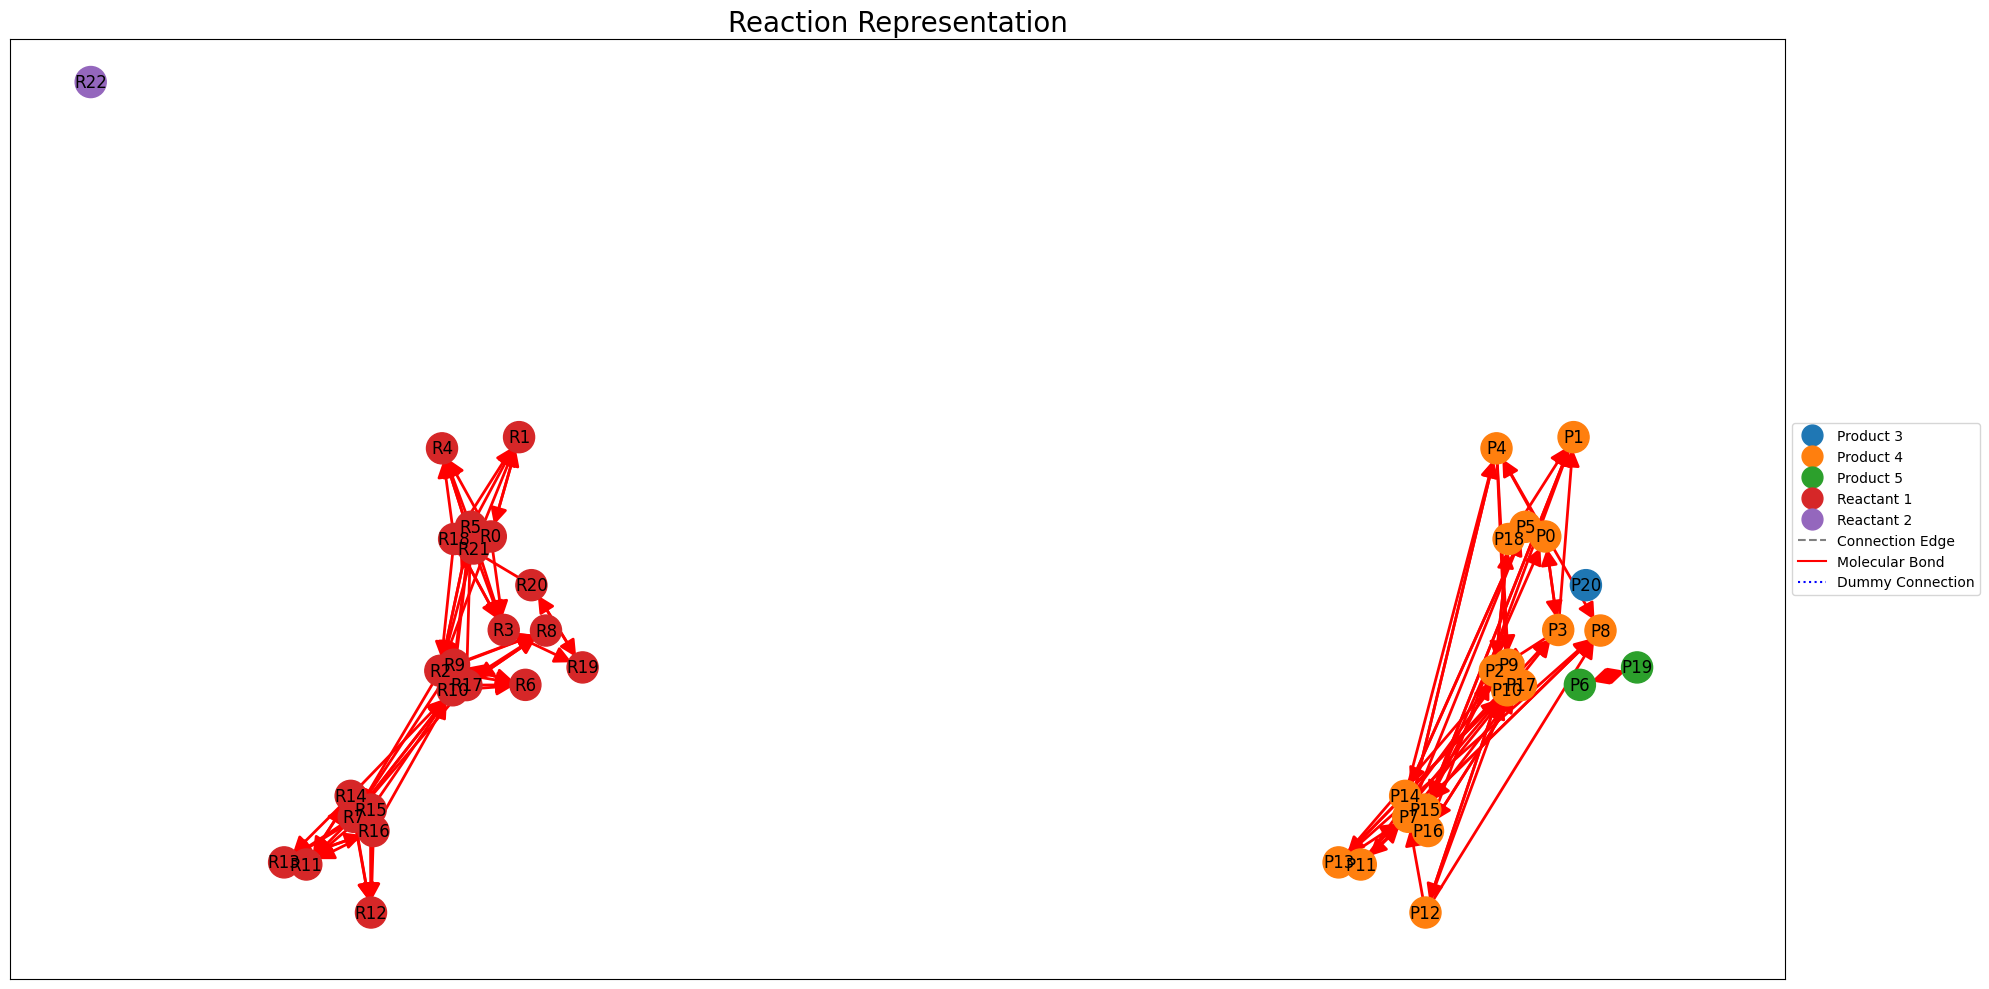

In [5]:
visualize_graphs(batch[0])

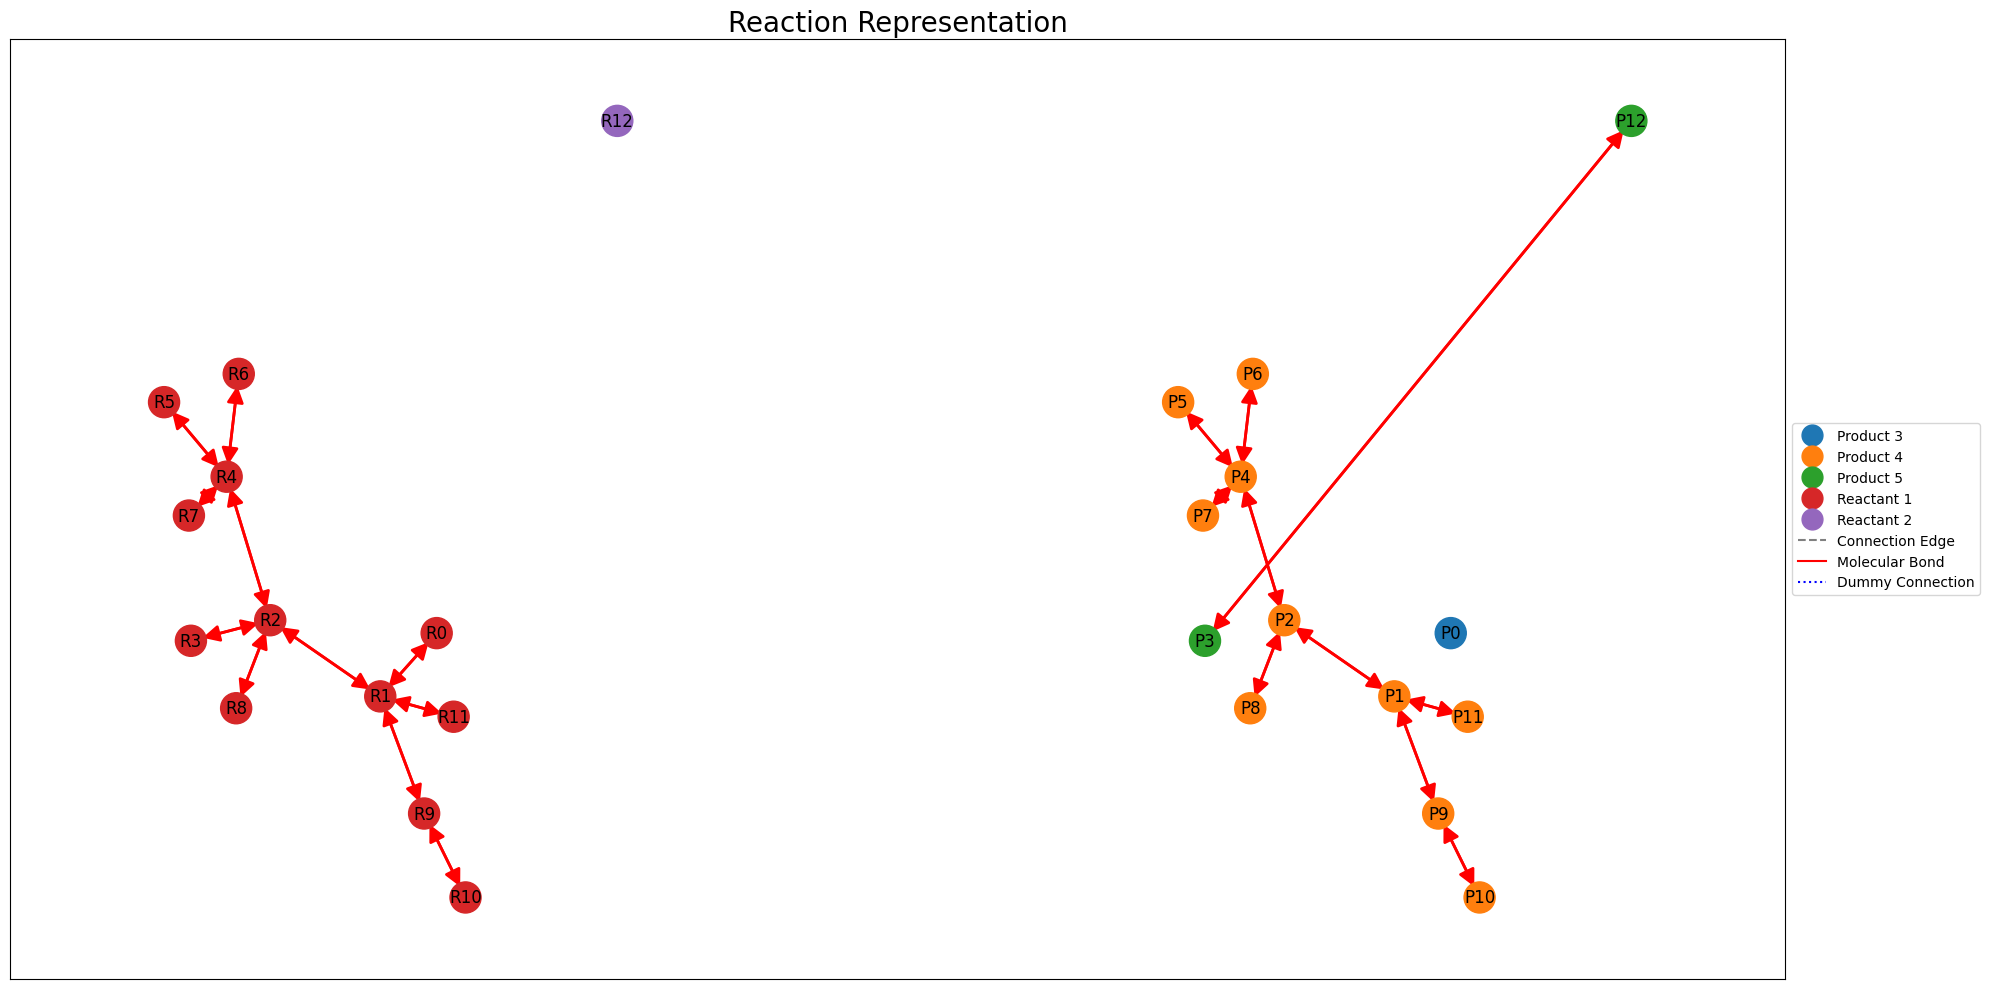

In [23]:
visualize_graphs(data_new[0])

In [6]:
data_new[0].edge_origin_encoding

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

In [16]:
edge_index = data_new[0].edge_index
print(edge_index)

tensor([[ 0,  1,  1,  2,  1,  9,  1, 11,  2,  3,  2,  4,  2,  8,  3, 12,  4,  5,
          4,  6,  4,  7,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
         12],
        [ 1,  0,  2,  1,  9,  1, 11,  1,  3,  2,  4,  2,  8,  2, 12,  3,  5,  4,
          6,  4,  7,  4, 10,  9, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13]])


In [17]:
data_new[0].atom_compound_idx

AttributeError: 'GlobalStorage' object has no attribute 'atom_compound_idx'

In [18]:
data_new[0].randomwalkpe

tensor([[0.0000, 0.2500, 0.0000, 0.1719, 0.0000, 0.1426, 0.0000, 0.1283, 0.0000,
         0.1195, 0.0000, 0.1132, 0.0000, 0.1084, 0.0000, 0.1047, 0.0000, 0.1018,
         0.0000, 0.0995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6875, 0.0000, 0.5703, 0.0000, 0.5132, 0.0000, 0.4778, 0.0000,
         0.4527, 0.0000, 0.4336, 0.0000, 0.4188, 0.0000, 0.4071, 0.0000, 0.3980,
         0.0000, 0.3907, 0.0000, 0.6111, 0.0000, 0.5031, 0.0000, 0.4546, 0.0000,
         0.4244, 0.0000, 0.4028, 0.0000, 0.3867, 0.0000, 0.3745, 0.0000, 0.3651,
         0.0000, 0.3578, 0.0000, 0.3522],
        [0.0000, 0.6250, 0.0000, 0.4766, 0.0000, 0.4150, 0.0000, 0.3885, 0.0000,
         0.3766, 0.0000, 0.3710, 0.0000, 0.3682, 0.0000, 0.3667, 0.0000, 0.3658,
         0.0000, 0.3652, 0.0000, 0.5278, 0.0000, 0.3966, 0.0000, 0.3555, 0.0000,
         0.3417, 0.0000, 

In [19]:
data_new[0].randomwalkpe

tensor([[0.0000, 0.2500, 0.0000, 0.1719, 0.0000, 0.1426, 0.0000, 0.1283, 0.0000,
         0.1195, 0.0000, 0.1132, 0.0000, 0.1084, 0.0000, 0.1047, 0.0000, 0.1018,
         0.0000, 0.0995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6875, 0.0000, 0.5703, 0.0000, 0.5132, 0.0000, 0.4778, 0.0000,
         0.4527, 0.0000, 0.4336, 0.0000, 0.4188, 0.0000, 0.4071, 0.0000, 0.3980,
         0.0000, 0.3907, 0.0000, 0.6111, 0.0000, 0.5031, 0.0000, 0.4546, 0.0000,
         0.4244, 0.0000, 0.4028, 0.0000, 0.3867, 0.0000, 0.3745, 0.0000, 0.3651,
         0.0000, 0.3578, 0.0000, 0.3522],
        [0.0000, 0.6250, 0.0000, 0.4766, 0.0000, 0.4150, 0.0000, 0.3885, 0.0000,
         0.3766, 0.0000, 0.3710, 0.0000, 0.3682, 0.0000, 0.3667, 0.0000, 0.3658,
         0.0000, 0.3652, 0.0000, 0.5278, 0.0000, 0.3966, 0.0000, 0.3555, 0.0000,
         0.3417, 0.0000, 

In [20]:
visualize_graphs(data_new[0])

ValueError: max() arg is an empty sequence

In [10]:
print(data_new[0].x[16])

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0101, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


In [8]:
print(data_new[0].x[1])

tensor([0., 0., 0., 0., 1., 0., 0.])


In [8]:
data_new[0].EigVals

tensor([[[0.0000e+00],
         [0.0000e+00]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [0.0000e+00]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [8.0033e-16]],

        [[0.0000e+00],
         [0.0000e+00]]])

In [9]:
data_new[0].EigVecs

tensor([[ 0.2887,  1.0000],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887, -0.7071],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 0.2887,  0.3162],
        [ 1.0000, -0.7071]])

In [31]:
for batch in train_loader:
    for i in range(len(batch)):
        if batch[i].smiles == "[Cl:1][C@:5]([C:4]([H:3])([C:31]([H:32])([H:33])[H:34])[C:41]([H:42])([H:43])[H:44])([N:11]([H:12])[H:13])[N+:21]([O-:22])[O:23].[H-:2]>>[C:4](=[C:5]([N:11]([H:12])[H:13])[N+:21]([O-:22])[O:23])([C:31]([H:32])([H:33])[H:34])[C:41]([H:42])([H:43])[H:44].[Cl-:1].[H:2][H:3]":
            sample = batch[i]

In [32]:
sample

Data(x=[38, 44], edge_index=[2, 66], edge_attr=[66, 11], y=[1], smiles='[Cl:1][C@:5]([C:4]([H:3])([C:31]([H:32])([H:33])[H:34])[C:41]([H:42])([H:43])[H:44])([N:11]([H:12])[H:13])[N+:21]([O-:22])[O:23].[H-:2]>>[C:4](=[C:5]([N:11]([H:12])[H:13])[N+:21]([O-:22])[O:23])([C:31]([H:32])([H:33])[H:34])[C:41]([H:42])([H:43])[H:44].[Cl-:1].[H:2][H:3]', atom_origin_type=[38], atom_compound_idx=[38])

In [46]:
from deeprxn.transform.lapPE import LapPE
pe = LapPE(eigvec_norm="L2", max_freqs=1, attr_name=["EigVals", "EigVecs"])
wow = pe(sample)
wow.EigVals, wow.EigVecs

(tensor([[[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]]]),
 tensor([[0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.

In [43]:
samples = split_reaction_graphs(sample)
samples[0]

Data(x=[18, 44], edge_index=[2, 34], edge_attr=[34, 11], y=[1], smiles='[Cl:1][C@:5]([C:4]([H:3])([C:31]([H:32])([H:33])[H:34])[C:41]([H:42])([H:43])[H:44])([N:11]([H:12])[H:13])[N+:21]([O-:22])[O:23].[H-:2]>>[C:4](=[C:5]([N:11]([H:12])[H:13])[N+:21]([O-:22])[O:23])([C:31]([H:32])([H:33])[H:34])[C:41]([H:42])([H:43])[H:44].[Cl-:1].[H:2][H:3]', atom_origin_type=[18], atom_compound_idx=[18])

In [44]:
from deeprxn.transform.lapPE import LapPE
pe = LapPE(eigvec_norm="L2", max_freqs=1, attr_name=["EigVals", "EigVecs"])
new_data = pe(samples[0])

In [45]:
new_data.EigVals, new_data.EigVecs

(tensor([[[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]]]),
 tensor([[0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357],
         [0.2357]]))

In [29]:

EigVals = new_data.EigVals
EigVecs = new_data.EigVecs

print(EigVecs.shape)
print(EigVals.shape)
sign_flip = torch.rand(EigVecs.size(1), device=EigVecs.device)
sign_flip[sign_flip >= 0.5] = 1.0
sign_flip[sign_flip < 0.5] = -1.0
EigVecs = EigVecs * sign_flip.unsqueeze(0)

print(EigVecs.shape)
print(EigVals.shape)

pos_enc = torch.cat(
    (EigVecs.unsqueeze(2), EigVals), dim=2
)
print(pos_enc.shape)
print(pos_enc)

torch.Size([18, 5])
torch.Size([18, 5, 1])
torch.Size([18, 5])
torch.Size([18, 5, 1])
torch.Size([18, 5, 2])
tensor([[[ 2.3570e-01,  0.0000e+00],
         [ 1.7839e-01,  1.2278e-01],
         [ 2.0726e-16,  2.0871e-01],
         [-7.4643e-19,  2.6795e-01],
         [ 5.6003e-01,  6.4792e-01]],

        [[ 2.3570e-01,  0.0000e+00],
         [ 1.5649e-01,  1.2278e-01],
         [ 1.6400e-16,  2.0871e-01],
         [-5.4643e-19,  2.6795e-01],
         [ 1.9717e-01,  6.4792e-01]],

        [[ 2.3570e-01,  0.0000e+00],
         [-9.5648e-02,  1.2278e-01],
         [ 8.8895e-17,  2.0871e-01],
         [ 4.2364e-16,  2.6795e-01],
         [ 2.1939e-01,  6.4792e-01]],

        [[ 2.3570e-01,  0.0000e+00],
         [-1.0904e-01,  1.2278e-01],
         [-7.1520e-18,  2.0871e-01],
         [ 6.2434e-16,  2.6795e-01],
         [ 6.2313e-01,  6.4792e-01]],

        [[ 2.3570e-01,  0.0000e+00],
         [-2.0915e-01,  1.2278e-01],
         [-2.9383e-01,  2.0871e-01],
         [ 1.5909e-15,  2.6795e-

In [37]:
import torch
from torch_geometric.data import Data

def split_reaction_graphs(data):
    """
    Split a reaction graph into its constituent molecular graphs.
    
    Args:
        data (Data): PyTorch Geometric Data object containing reaction graph
        
    Returns:
        list[Data]: List of Data objects, one per molecule
    """
    unique_compounds = torch.unique(data.atom_compound_idx)
    split_graphs = []
    
    for compound_idx in unique_compounds:
        # Create node mask
        node_mask = data.atom_compound_idx == compound_idx
        node_idx_map = torch.cumsum(node_mask, 0) - 1
        
        # Filter nodes
        x = data.x[node_mask]
        atom_origin_type = data.atom_origin_type[node_mask]
        
        # Filter edges
        edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
        edge_index = data.edge_index[:, edge_mask]
        edge_attr = data.edge_attr[edge_mask]
        
        # Remap edge indices
        edge_index = node_idx_map[edge_index]
        
        # Create new Data object
        mol_graph = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=data.y,
            smiles=data.smiles,
            atom_origin_type=atom_origin_type,
            atom_compound_idx=torch.full((len(x),), compound_idx, dtype=torch.long)
        )
        
        split_graphs.append(mol_graph)
    
    return split_graphs

# Quick test
test_graphs = split_reaction_graphs(data_new[0])
print(f"Number of split graphs: {len(test_graphs)}")
print(f"Nodes in first graph: {test_graphs[0].x.shape[0]}")

Number of split graphs: 5
Nodes in first graph: 12


In [7]:
test_graphs[1]

Data(x=[1, 44], edge_index=[2, 0], edge_attr=[0, 11], y=[1], smiles='[Br:1][C@:5]([C:4]([H:3])([C:31]([H:32])([H:33])[H:34])[H:41])([C:11]#[N:12])[H:21].[H-:2]>>[Br-:1].[C:4](=[C:5](/[C:11]#[N:12])[H:21])(\[C:31]([H:32])([H:33])[H:34])[H:41].[H:2][H:3]', atom_origin_type=[1], atom_compound_idx=[1])

In [8]:
test_graphs[1] = pe(test_graphs[1])
test_graphs[1].EigVals, test_graphs[1].EigVecs

(tensor([[[0.],
          [nan],
          [nan],
          [nan],
          [nan]]]),
 tensor([[1., nan, nan, nan, nan]]))

In [5]:
data_new[0].pestat_RWSE

tensor([[0.0000, 0.2500, 0.0000, 0.1719, 0.0000, 0.1426, 0.0000, 0.1283, 0.0000,
         0.1195, 0.0000, 0.1132, 0.0000, 0.1084, 0.0000, 0.1047, 0.0000, 0.1018,
         0.0000, 0.0995],
        [0.0000, 0.6875, 0.0000, 0.5703, 0.0000, 0.5132, 0.0000, 0.4778, 0.0000,
         0.4527, 0.0000, 0.4336, 0.0000, 0.4188, 0.0000, 0.4071, 0.0000, 0.3980,
         0.0000, 0.3907],
        [0.0000, 0.6250, 0.0000, 0.4766, 0.0000, 0.4150, 0.0000, 0.3885, 0.0000,
         0.3766, 0.0000, 0.3710, 0.0000, 0.3682, 0.0000, 0.3667, 0.0000, 0.3658,
         0.0000, 0.3652],
        [0.0000, 0.2500, 0.0000, 0.1562, 0.0000, 0.1191, 0.0000, 0.1038, 0.0000,
         0.0971, 0.0000, 0.0941, 0.0000, 0.0927, 0.0000, 0.0920, 0.0000, 0.0917,
         0.0000, 0.0914],
        [0.0000, 0.8125, 0.0000, 0.6953, 0.0000, 0.6157, 0.0000, 0.5584, 0.0000,
         0.5156, 0.0000, 0.4828, 0.0000, 0.4573, 0.0000, 0.4374, 0.0000, 0.4218,
         0.0000, 0.4096],
        [0.0000, 0.2500, 0.0000, 0.2031, 0.0000, 0.1738, 0.0

In [4]:
data_new[0].randomwalkpe

tensor([[0.0000, 0.2500, 0.0000, 0.1719, 0.0000, 0.1426, 0.0000, 0.1283, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6875, 0.0000, 0.5703, 0.0000, 0.5132, 0.0000, 0.4778, 0.0000,
         0.5278, 0.0000, 0.3966, 0.0000, 0.3555, 0.0000, 0.3417],
        [0.0000, 0.6250, 0.0000, 0.4766, 0.0000, 0.4150, 0.0000, 0.3885, 0.0000,
         0.6111, 0.0000, 0.5031, 0.0000, 0.4546, 0.0000, 0.4244],
        [0.0000, 0.2500, 0.0000, 0.1562, 0.0000, 0.1191, 0.0000, 0.1038, 0.0000,
         1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 0.8125, 0.0000, 0.6953, 0.0000, 0.6157, 0.0000, 0.5584, 0.0000,
         0.2500, 0.0000, 0.2083, 0.0000, 0.1829, 0.0000, 0.1654],
        [0.0000, 0.2500, 0.0000, 0.2031, 0.0000, 0.1738, 0.0000, 0.1539, 0.0000,
         0.2500, 0.0000, 0.2083, 0.0000, 0.1829, 0.0000, 0.1654],
        [0.0000, 0.2500, 0.0000, 0.2031, 0.0000, 0.1738, 0.0000, 0.1539, 0.0000,
         0.3333, 0.0000, 0.1759, 0.00

In [7]:
from deeprxn.transform.randomwalkpe import RandomWalkPETransform
pe = RandomWalkPETransform(walk_length=8, attr_name="pe")
new_data = pe(data_new[0])

In [8]:
new_data.pe

tensor([[0.0000, 0.2500, 0.0000, 0.1719, 0.0000, 0.1426, 0.0000, 0.1283],
        [0.0000, 0.6875, 0.0000, 0.5703, 0.0000, 0.5132, 0.0000, 0.4778],
        [0.0000, 0.6250, 0.0000, 0.4766, 0.0000, 0.4150, 0.0000, 0.3885],
        [0.0000, 0.2500, 0.0000, 0.1562, 0.0000, 0.1191, 0.0000, 0.1038],
        [0.0000, 0.8125, 0.0000, 0.6953, 0.0000, 0.6157, 0.0000, 0.5584],
        [0.0000, 0.2500, 0.0000, 0.2031, 0.0000, 0.1738, 0.0000, 0.1539],
        [0.0000, 0.2500, 0.0000, 0.2031, 0.0000, 0.1738, 0.0000, 0.1539],
        [0.0000, 0.2500, 0.0000, 0.2031, 0.0000, 0.1738, 0.0000, 0.1539],
        [0.0000, 0.2500, 0.0000, 0.1562, 0.0000, 0.1191, 0.0000, 0.1038],
        [0.0000, 0.6250, 0.0000, 0.4609, 0.0000, 0.3760, 0.0000, 0.3249],
        [0.0000, 0.5000, 0.0000, 0.3125, 0.0000, 0.2305, 0.0000, 0.1880],
        [0.0000, 0.2500, 0.0000, 0.1719, 0.0000, 0.1426, 0.0000, 0.1283],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.000

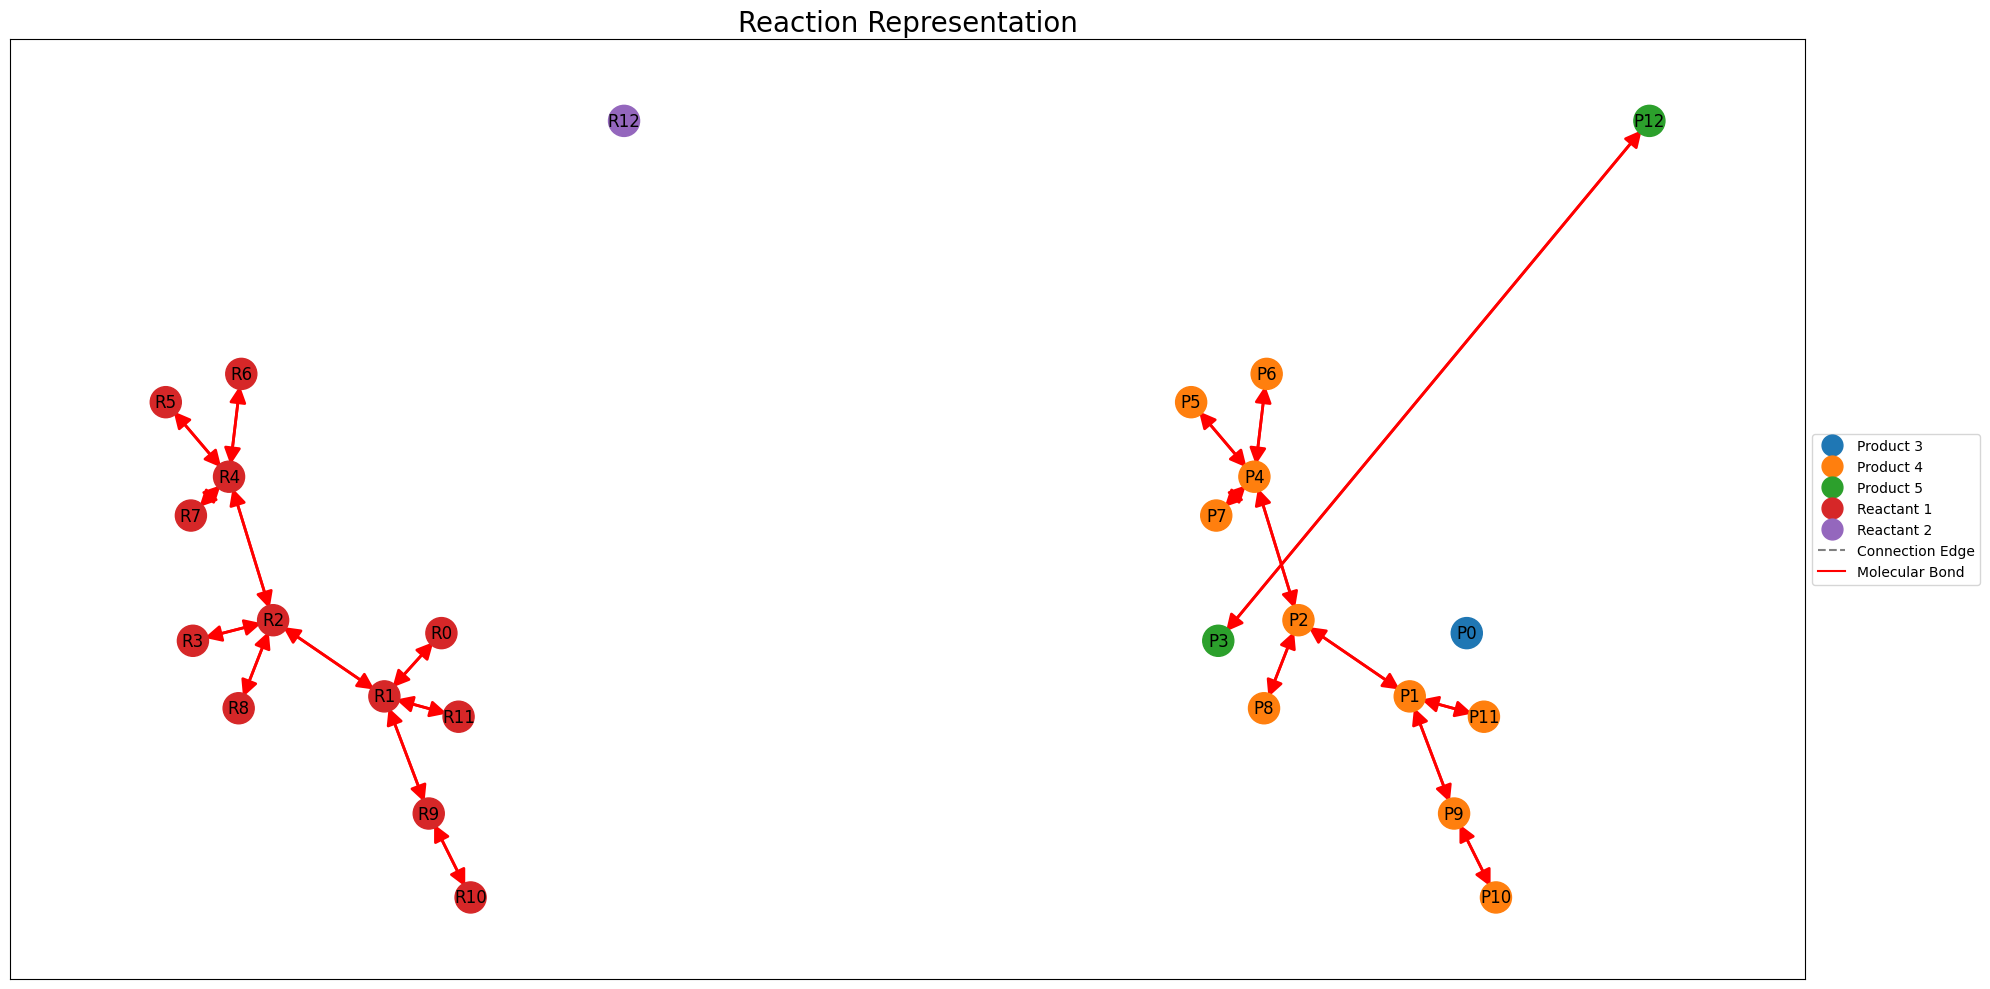

In [5]:
visualize_graphs(data_new[0])

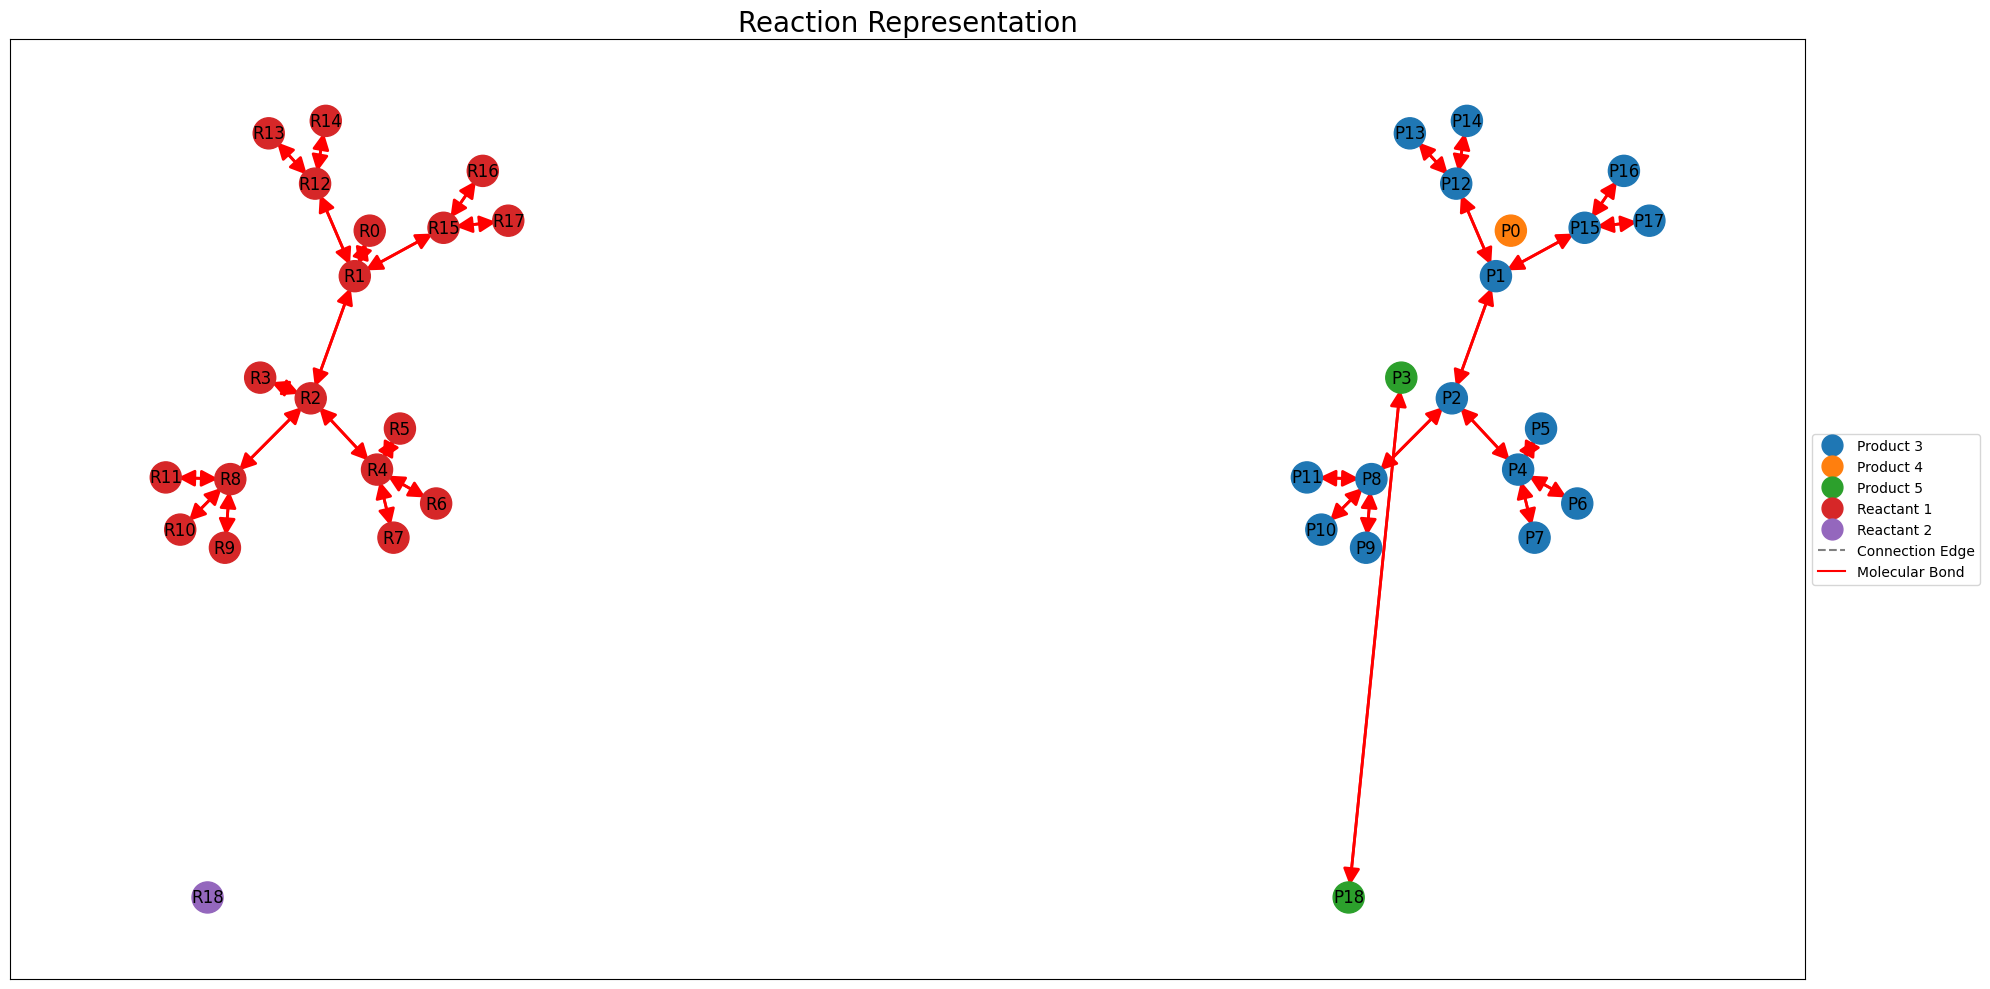

In [6]:
visualize_graphs(sample)

In [11]:
import torch

# Simulate your problematic tensors
reac_feat = torch.tensor([[0.]])  # Shape: [1,1]
prod_feat = torch.tensor([[0.]])  # Shape: [1,1]
print(reac_feat)
print(prod_feat)

# Current problematic code:
result = torch.cat([reac_feat, prod_feat])  # This will fail
result

tensor([[0.]])
tensor([[0.]])


tensor([[0.],
        [0.]])

In [7]:
import torch

# Simulate your problematic tensors
reac_feat = torch.tensor([[0.]])  # Shape: [1,1]
prod_feat = torch.tensor([[0.]])  # Shape: [1,1]

# Current problematic code:
try:
    result = torch.cat([reac_feat, prod_feat])  # This will fail
except RuntimeError as e:
    print("Error with original code:", e)

# Solution 1: Flatten the tensors first
reac_feat_flat = reac_feat.flatten()  # Shape: [1]
prod_feat_flat = prod_feat.flatten()  # Shape: [1]
result1 = torch.cat([reac_feat_flat, prod_feat_flat])
print("\nSolution 1 (flatten first):")
print("Result shape:", result1.shape)
print("Result:", result1)

# Solution 2: Specify the dimension
result2 = torch.cat([reac_feat, prod_feat], dim=1)  # Concatenate along columns
print("\nSolution 2 (specify dimension):")
print("Result shape:", result2.shape)
print("Result:", result2)

# For your specific code, modify the merge line to:
print("\nModified code for your case:")
merged = torch.cat([reac_feat.flatten(), prod_feat.flatten()])
print("Final result shape:", merged.shape)
print("Final result:", merged)


Solution 1 (flatten first):
Result shape: torch.Size([2])
Result: tensor([0., 0.])

Solution 2 (specify dimension):
Result shape: torch.Size([1, 2])
Result: tensor([[0., 0.]])

Modified code for your case:
Final result shape: torch.Size([2])
Final result: tensor([0., 0.])


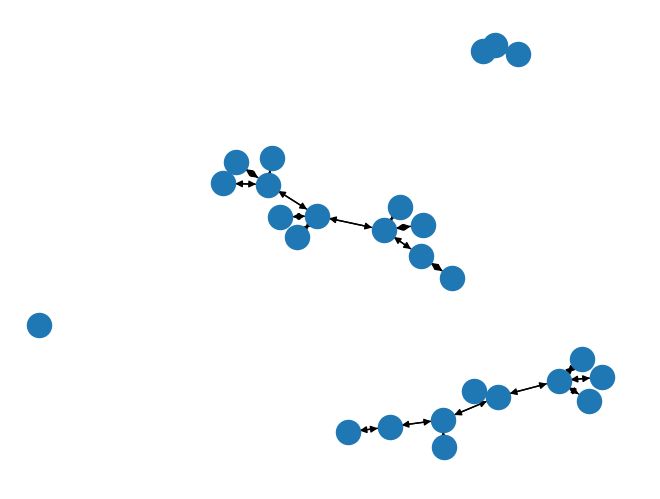

In [10]:
def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

G = create_graph(new_data)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos)

In [2]:
import torch
from torch_geometric.utils import to_dense_batch
x = torch.arange(12).view(6, 2)
batch = torch.tensor([0, 0, 1, 3, 3, 3])
out, mask = to_dense_batch(x, batch=None, max_num_nodes=2)
print(x)
print(out)
print(mask)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]])
tensor([[[0, 1],
         [2, 3]]])
tensor([[True, True]])


# TODO: write script that automatically visualizes graph of given config
### TODO: update code

In [3]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="features")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(0)

atom_featurizer = make_featurizer("atom_rdkit_organic")
bond_featurizer = make_featurizer("bond_rdkit_base")
cfg.dataset_name = "barriers_rdb7" # "barriers_e2", "barriers_rdb7"
cfg.representation = "CGR" # connected_pair, CGR
cfg.connection_direction = "bidirectional" # None, bidirectional, reactants_to_products, products_to_reactants
cfg.dummy_node = "global" # global, all_separate, reactant_product, None
cfg.dummy_connection = "bidirectional"
cfg.batch_size = 2

train_loader = hydra.utils.instantiate(
    cfg, shuffle=True, split="train"
)

data = next(iter(train_loader))


In [4]:
data

DataBatch(x=[34, 88], edge_index=[2, 132], edge_attr=[132, 22], y=[2], smiles=[2], is_real_bond=[64], atom_origin_type=[34], atom_origins=[2], incoming_edges_list=[780], incoming_edges_batch=[780], neighboring_nodes_list=[162], neighboring_nodes_batch=[162], incoming_edges_nodes_list=[162], incoming_edges_nodes_batch=[162], batch=[34], ptr=[3])

In [2]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="cfg2")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(cfg.seed)
cfg.data.batch_size = 2
train_loader = hydra.utils.instantiate(
    cfg.data, shuffle=True, split="train"
)
data_new = next(iter(train_loader))

InstantiationException: Error in call to target 'deeprxn.data.construct_loader':
TypeError("RandomWalkPETransform.add_node_attr() got multiple values for argument 'attr_name'")
full_key: data

In [6]:
data_new

DataBatch(x=[34, 88], edge_index=[2, 132], edge_attr=[132, 22], y=[2], smiles=[2], atom_origin_type=[34], batch=[34], ptr=[3])

In [11]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(cfg.seed)

cfg.features.atom_featurizer = "atom_rdkit_organic"
cfg.features.bond_featurizer = "bond_rdkit_base"
atom_featurizer = make_featurizer(cfg.features.atom_featurizer)
bond_featurizer = make_featurizer(cfg.features.bond_featurizer)
cfg.data.dataset_name = "barriers_rdb7" # "barriers_e2", "barriers_rdb7"
cfg.transformation.representation = "connected_pair" # connected_pair, CGR
cfg.transformation.connection_direction = "bidirectional" # None, bidirectional, reactants_to_products, products_to_reactants
cfg.transformation.dummy_node = None # global, all_separate, reactant_product, None
cfg.transformation.batch_size = 3

# train_loader = hydra.utils.instantiate(
#     cfg.transformation, shuffle=True, split="train"
# )
test_loader = hydra.utils.instantiate(
    cfg.transformation, shuffle=False, split="test"
)
data = next(iter(test_loader))

# model
cfg.model.num_node_features = test_loader.dataset.num_node_features
cfg.model.num_edge_features = test_loader.dataset.num_edge_features
cfg.model.depth = 3
cfg.model.hidden_size = 300
cfg.model.dropout = 0.02
cfg.model.pool_type = "global"
cfg.model.return_attention_weights = True
cfg.model.shared_weights = True
cfg.model.use_attention_agg = True

model = hydra.utils.instantiate(cfg.model)
#print(model)

In [12]:
cfg.model_path = "saved_models/full/"
model_path = os.path.join(cfg.model_path, "model.pt")
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])
epoch = checkpoint["epoch"]
best_val_loss = checkpoint["best_val_loss"]
mean, std = load_standardizer(cfg.model_path)
stdzer = Standardizer(mean, std)
model.eval()
with torch.no_grad():
    output = model(data)
    
print("Got output of type:", type(output))
print("Output shape:", [t.shape if torch.is_tensor(t) else type(t) for t in output])

Got output of type: <class 'tuple'>
Output shape: [torch.Size([3]), torch.Size([1, 222, 148])]


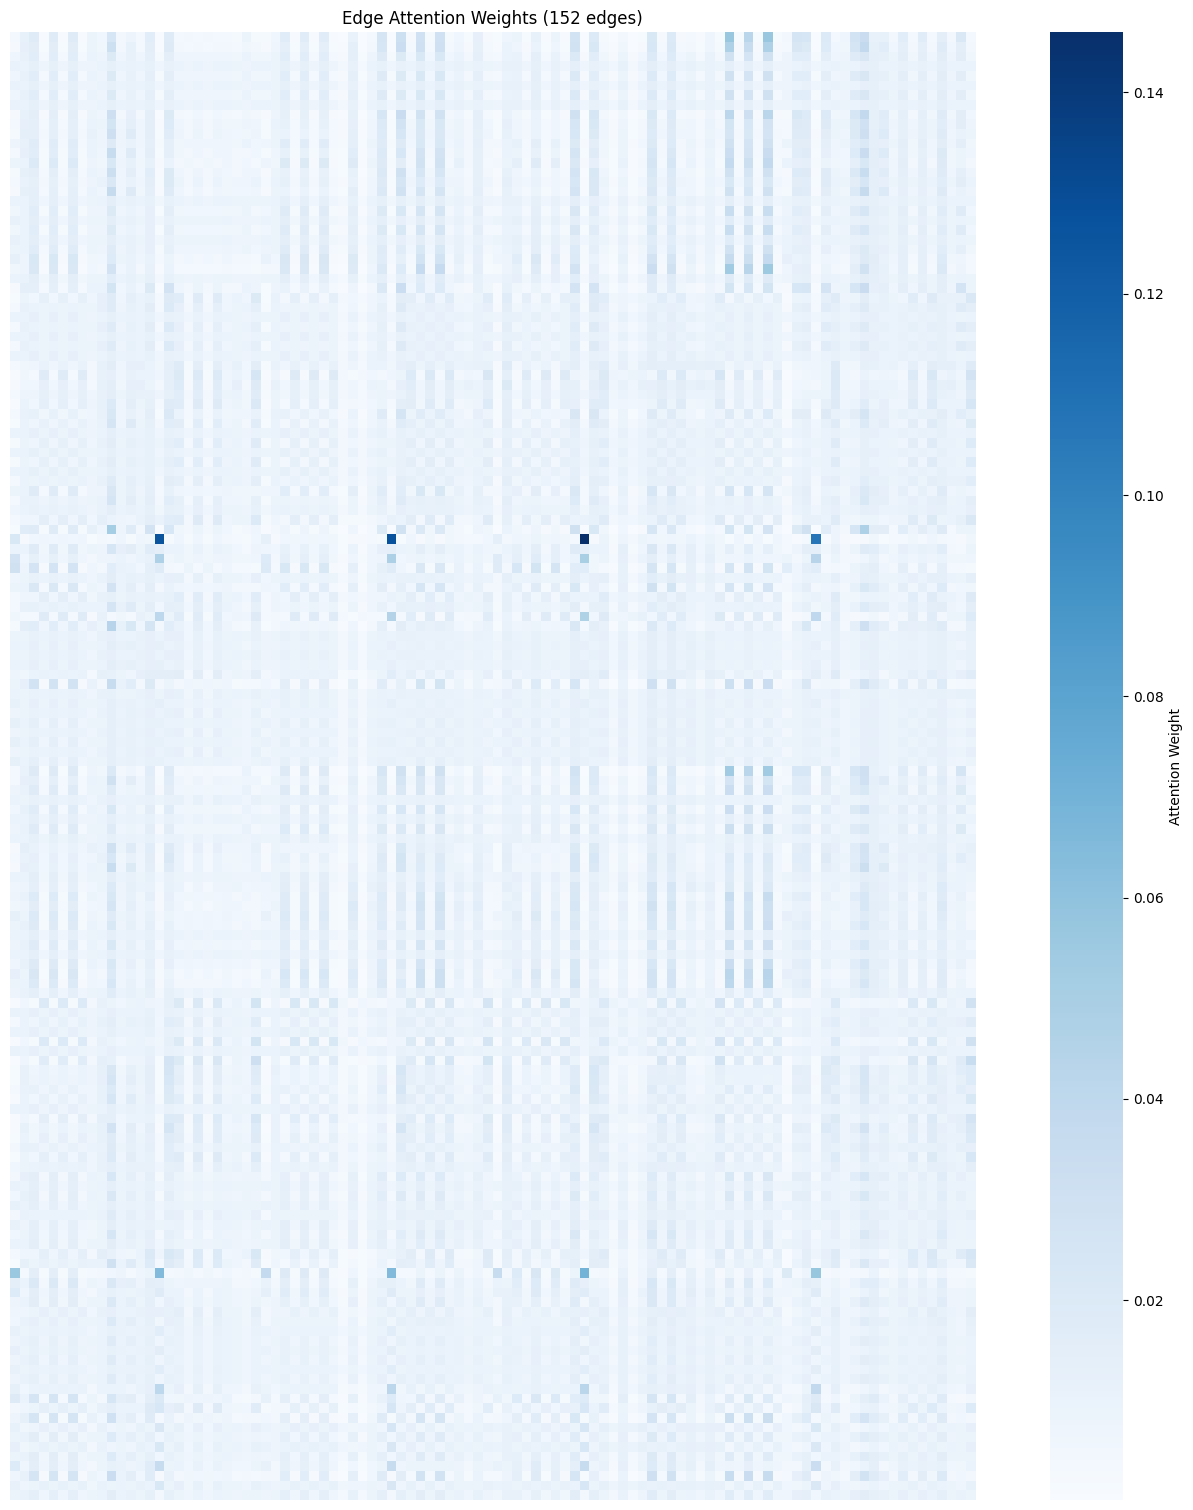

In [10]:
import numpy as np
import seaborn as sns

def plot_attention_heatmap(attention_weights):
    """
    Creates a heatmap visualization of attention weights for large graphs
    
    Args:
        attention_weights: tensor of shape [num_heads, num_edges, max_edges_per_node]
    """
    # Get weights from first head and convert to numpy
    weights = attention_weights[0].numpy()
    
    # Create figure with appropriate size scaling
    scale = max(8, min(20, weights.shape[0] / 10))  # Dynamic figure scaling
    plt.figure(figsize=(scale, scale))
    
    # Create heatmap without labels
    sns.heatmap(
        weights,
        cmap='Blues',
        xticklabels=False,
        yticklabels=False,
        cbar_kws={'label': 'Attention Weight'},
        square=True  # Make cells square
    )
    
    # Add minimal labels
    plt.title(f'Edge Attention Weights ({weights.shape[0]} edges)')
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Get attention weights from output
_, attention_weights = output

# Create and show heatmap
fig = plot_attention_heatmap(attention_weights)
plt.show()

In [7]:
sample = data

print(f"Node features [num_atoms, num_atom_feat]: {sample.x.shape}")
print(f"Edge index [2, num_bond]: {sample.edge_index.shape}")
print(f"Edge attributes [num_bond, num_bond_feat]: {sample.edge_attr.shape}")
print(f"Target label: {sample.y.shape}")
print(f"Atom origin type: {sample.atom_origin_type.shape}")
print(f"Is real bond: {sample.is_real_bond.shape}, real bonds: {sample.is_real_bond.sum()}, fake bonds: {(~sample.is_real_bond).sum()}")

Node features [num_atoms, num_atom_feat]: torch.Size([26, 44])
Edge index [2, num_bond]: torch.Size([2, 76])
Edge attributes [num_bond, num_bond_feat]: torch.Size([76, 11])
Target label: torch.Size([1])
Atom origin type: torch.Size([26])
Is real bond: torch.Size([76]), real bonds: 50, fake bonds: 26


In [22]:
row = sample.edge_index[0]
edge_batch = sample.batch[row]
edge_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
from typing import Literal, Optional, Tuple

import torch
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.utils import to_dense_batch
import torch.nn.functional as F
from deeprxn.data import AtomOriginType

lin_real = nn.Linear(300, 300)
lin_artificial = (
    nn.Linear(300, 300)
)
attention = nn.MultiheadAttention(
            300,
            num_heads=1,
            dropout=0.02,
            batch_first=True,
        )

edge_init = nn.Linear(train_loader.dataset.num_node_features + train_loader.dataset.num_edge_features, 300)

x = data.x
edge_index = data.edge_index
edge_attr = data.edge_attr
batch = data.batch
atom_origin_type = data.atom_origin_type
incoming_edges_list = data.incoming_edges_list
incoming_edges_batch = data.incoming_edges_batch
edge_batch = torch.unique(incoming_edges_batch, sorted=False)
row, col = edge_index
h_0 = F.relu(edge_init(torch.cat([x[row], edge_attr], dim=1)))
h = h_0

In [12]:
edge_attr = h
row, col = edge_index
max_edges_per_node = 4
edge_attr_2 = edge_attr[edge_batch]
edge_attr_dense, mask_edge_attr_dense = to_dense_batch(
    edge_attr_2, batch=edge_batch, batch_size=len(edge_attr)
) # [num_batches, max_nodes_per_batch, hidden_size]
edge_attr_rearranged = edge_attr[incoming_edges_list]
# [num_batches, max_nodes_per_batch, hidden_size], [num_batches, max_nodes_per_batch]
incoming_edges, mask = to_dense_batch(
    edge_attr_rearranged,
    batch=incoming_edges_batch,
    max_num_nodes=max_edges_per_node,
    batch_size=len(edge_attr),
)
# Q: single edges, K: respective incoming edges, V: respective incoming edges
edge_attr_dense_updated, _ = attention(
    edge_attr_dense,
    incoming_edges,
    incoming_edges,
    key_padding_mask=~mask,
    need_weights=False,
)
edge_attr_dense_updated = edge_attr_dense_updated[mask_edge_attr_dense]
# residual connection
edge_attr_att_output = edge_attr.clone()
edge_attr_att_output[edge_batch] = (
    edge_attr_att_output[edge_batch] + edge_attr_dense_updated
)
edge_attr_att_output

tensor([[ 0.0000,  0.0000,  0.0686,  ...,  0.0206,  0.0000,  0.0000],
        [-0.0199,  0.1403, -0.0680,  ..., -0.0039, -0.1153, -0.0495],
        [-0.0243,  0.1344, -0.0601,  ...,  0.0044, -0.0817, -0.0502],
        ...,
        [ 0.0000,  0.0694,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1622,  0.2699, -0.0451,  ..., -0.0435, -0.0347, -0.1579],
        [ 0.0000,  0.1613,  0.0000,  ...,  0.0000,  0.1918,  0.0000]],
       grad_fn=<IndexPutBackward0>)

### Connected pair visualization

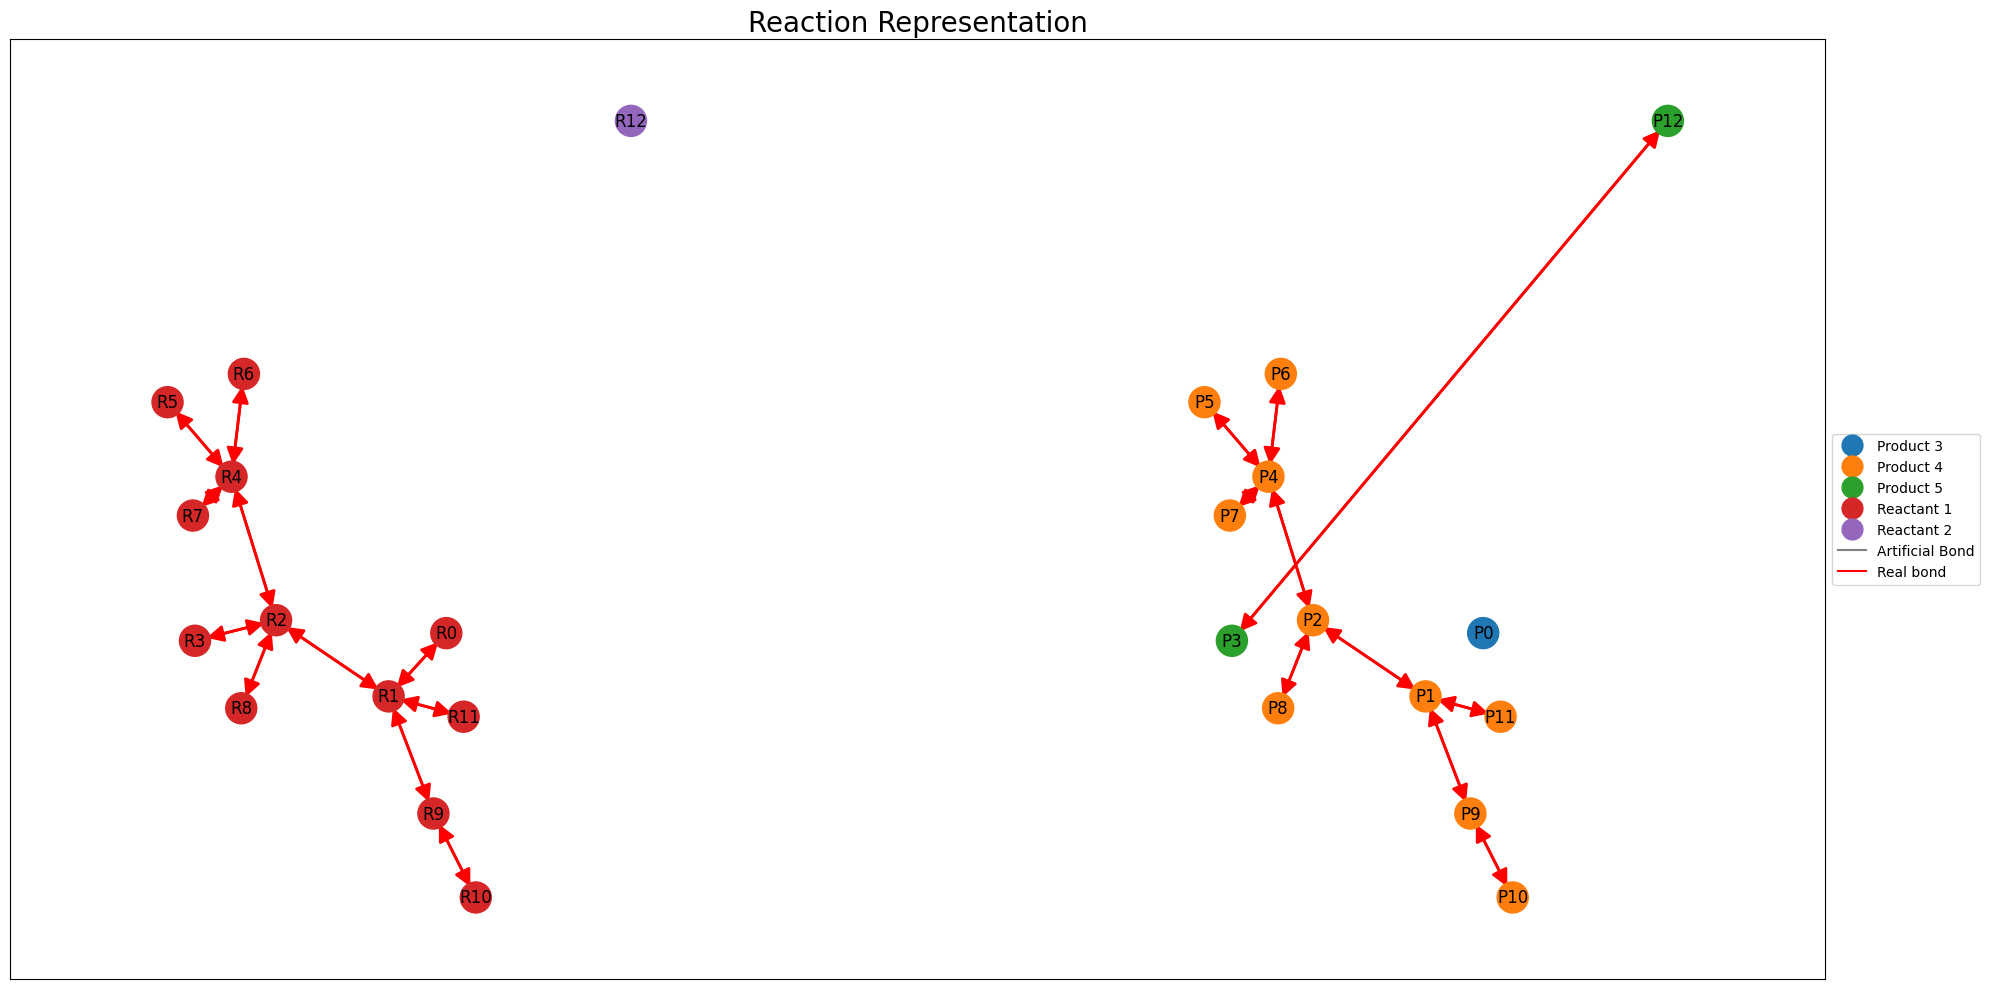

In [6]:
def generate_color_palette(n):
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    return base_colors * (n // len(base_colors) + 1)

def split_data(data):
    reactant_mask = data.atom_origin_type == AtomOriginType.REACTANT
    product_mask = data.atom_origin_type == AtomOriginType.PRODUCT
    
    reactants = data.clone()
    reactants.x = data.x[reactant_mask]
    reactants.edge_index, reactants.edge_attr = subgraph(reactant_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    products = data.clone()
    products.x = data.x[product_mask]
    products.edge_index, products.edge_attr = subgraph(product_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    return reactants, products

def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

def position_nodes(G_reactants, G_products, G_full):
    pos_reactants = nx.spring_layout(G_reactants, seed=42)
    
    max_x = max(pos[0] for pos in pos_reactants.values())
    
    shift = max_x + 2.0
    
    pos_products = {node + len(G_reactants): (x + shift, y) for node, (x, y) in pos_reactants.items()}
    
    pos_combined = pos_reactants.copy()
    pos_combined.update(pos_products)
    
    dummy_nodes = [node for node in G_full.nodes() if data.atom_origin_type[node] == AtomOriginType.DUMMY]
    if dummy_nodes:
        dummy_x_center = (max_x + shift) / 2
        dummy_y = 0
        dummy_x_spread = 0.2
        for i, dummy_node in enumerate(dummy_nodes):
            offset = (i - (len(dummy_nodes) - 1) / 2) * dummy_x_spread
            pos_combined[dummy_node] = (dummy_x_center + offset, dummy_y)
    
    return pos_combined

def visualize_graphs(data):
    reactants, products = split_data(data)

    G_reactants = create_graph(reactants)
    G_products = create_graph(products)
    G_full = create_graph(data)

    pos_combined = position_nodes(G_reactants, G_products, G_full)

    fig, ax = plt.subplots(figsize=(20, 10))

    atom_groups = []
    for atom_type, atom_origin in zip(data.atom_origin_type, data.atom_origins):
        if atom_type == AtomOriginType.DUMMY:
            atom_groups.append('Dummy')
        elif atom_type == AtomOriginType.REACTANT:
            atom_groups.append(f'Reactant {atom_origin + 1}')
        else:
            atom_groups.append(f'Product {atom_origin + 1}')

    unique_groups = sorted(set(atom_groups))
    color_palette = generate_color_palette(len(unique_groups))
    color_map = dict(zip(unique_groups, color_palette))
    
    node_color_map = [color_map[group] for group in atom_groups]

    nx.draw_networkx_nodes(G_full, pos_combined, ax=ax, node_color=node_color_map, node_size=500)

    labels = {}
    reactant_count = 0
    product_count = 0
    dummy_count = 0
    for i, atom_type in enumerate(data.atom_origin_type):
        if atom_type == AtomOriginType.DUMMY:
            labels[i] = f'D{dummy_count}'
            dummy_count += 1
        elif atom_type == AtomOriginType.REACTANT:
            labels[i] = f'R{reactant_count}'
            reactant_count += 1
        else:
            labels[i] = f'P{product_count}'
            product_count += 1

    nx.draw_networkx_labels(G_full, pos_combined, labels, ax=ax, font_size=12)

    non_real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if not real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=non_real_edges, edge_color='gray', arrows=True, arrowsize=25, width=1.5)

    real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=real_edges, edge_color='r', arrows=True, arrowsize=25, width=2)

    for group, color in color_map.items():
        ax.plot([], [], color=color, marker='o', markersize=15, linestyle='', label=group)
    ax.plot([], [], 'gray', label='Artificial Bond')
    ax.plot([], [], 'r-', label='Real bond')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title("Reaction Representation", fontsize=20)
    plt.tight_layout()
    plt.show()

visualize_graphs(sample)

### For now, CGR

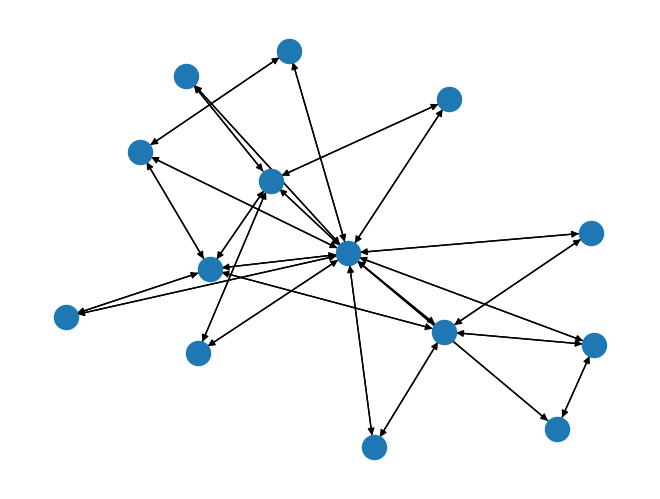

In [14]:
def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

G = create_graph(sample)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos)

In [11]:
# class RxnGraph:
#     # TODO: add docstring
#     # TODO (maybe): add support for unbalanced reactions?
#     def __init__(
#         self,
#         smiles,
#         atom_featurizer,
#         bond_featurizer,
#         representation="CGR",
#         connection_direction="bidirectional",
#         dummy_node=None,
#         dummy_connection="to_dummy",
#         dummy_dummy_connection="bidirectional",
#         dummy_feat_init="zeros",
#     ):
from deeprxn.data import MolGraph
import torch
from rdkit import Chem

def make_mol(smi):
    params = Chem.SmilesParserParams()
    params.removeHs = False
    return Chem.MolFromSmiles(smi,params)

class MolGraph:
    def __init__(self, smiles, atom_featurizer, bond_featurizer):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = make_mol(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom = atom_featurizer(mol.GetAtomWithIdx(a1))
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is None:
                    continue
                f_bond = bond_featurizer(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

molgraph_1 = MolGraph("[H][O][H]", atom_featurizer, bond_featurizer)
edge_index_1 = torch.tensor(molgraph_1.edge_index, dtype=torch.long).t().contiguous()
print(edge_index_1)

edge_attr_1 = torch.tensor([[0.111,0.156,0.0],
                          [0.222,0.199,0.0],
                          [0.0,0.0,0.133],
                          [0.0,0.288,0.0]], dtype=torch.float)
print(edge_attr_1)

molgraph_2 = MolGraph("[H][O]", atom_featurizer, bond_featurizer)
edge_index_2 = torch.tensor(molgraph_2.edge_index, dtype=torch.long).t().contiguous()
edge_index_2 += 3
print(edge_index_2)

edge_attr_2 = torch.tensor([[0.888,0.666,0.0],
                          [0.444,0.999,0.0]], dtype=torch.float)
print(edge_attr_2)

# merge two graphs
edge_index = torch.cat([edge_index_1, edge_index_2], dim=1)
edge_attr = torch.cat([edge_attr_1, edge_attr_2], dim=0)
print(edge_index)
print(edge_attr)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000]])
tensor([[3, 4],
        [4, 3]])
tensor([[0.8880, 0.6660, 0.0000],
        [0.4440, 0.9990, 0.0000]])
tensor([[0, 1, 1, 2, 3, 4],
        [1, 0, 2, 1, 4, 3]])
tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000],
        [0.8880, 0.6660, 0.0000],
        [0.4440, 0.9990, 0.0000]])
